[View in Colaboratory](https://colab.research.google.com/github/ylongqi/openrec/blob/master/tutorials/OpenRec_Basics_Diversity_and_Fairness.ipynb)

<p align="center">
  <img src ="https://recsys.acm.org/wp-content/uploads/2017/07/recsys-18-small.png" height="40" /> <font size="4">Recsys 2018 Tutorial</font>
</p>
<p align="center">
  <font size="4"><b>Modularizing Deep Neural Network-Inspired Recommendation Algorithms</b></font>
</p>
<p align="center">
  <font size="4">Hands on: Intro to OpenRec + diversity and fairness</font>
</p>

# Part1. Get started with the framework and look into per-group accuracy of recommendations

Recommender systems contain multiple pieces that needed to be implemented: data processing, model training, inference. OpenRec allows to use modularized approach to implement different pieces separately and reuse them for different recommenders. 

## here is the sample pipeline

<p align="center">
 <img src ="https://s3.amazonaws.com/cornell-tech-sdl-openrec/tutorials/pipeline.png" width="500" height=“20” />
</p>


## data

For this tutorial we use Last.fm dataset with 1K users history. This is a toy problem and you can explore larger dataset examples in our repo (Amazon, CiteULike, Tradesy).


![alt text](https://s3.amazonaws.com/cornell-tech-sdl-openrec/lastfm/fairness/last.png)


* 1000 users
* 15000 items
* 570K entries

## task

1. Recommend artists that a user will like.
2. Evaluate the performance on different user groups


In [1]:
# !pip install tensorflow
# !pip install matplotlib
# !pip install openrec

import urllib.request

dataset_prefix = 'http://s3.amazonaws.com/cornell-tech-sdl-openrec'
urllib.request.urlretrieve('%s/lastfm/fairness/lastfm1k.npy' % dataset_prefix, 
                   'lastfm1k.npy')
urllib.request.urlretrieve('%s/lastfm/fairness/lastfm_artists.json' % dataset_prefix, 
                   'lastfm_artists.json')
urllib.request.urlretrieve('%s/lastfm/fairness/lastfm_users.json' % dataset_prefix, 
                   'lastfm_users.json')

('lastfm_users.json', <http.client.HTTPMessage at 0x7fcee6f872e8>)

In [2]:
import tensorflow as tf
import random

random.seed(1)
tf.set_random_seed(1)
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

## load data and split into train and test set

In [3]:
# load data

raw_data = dict()
raw_data['max_user'] = 992
raw_data['max_item'] = 14598
data = np.load('./lastfm1k.npy')
range_ids = list(range(data.shape[0]))
random.shuffle(range_ids)

print("data sample:\t", data[0])
print("data type:\t", data[0].dtype)
print("data shape:\t", data.shape)

data sample:	 (912, 3121)
data type:	 [('user_id', '<i4'), ('item_id', '<i4')]
data shape:	 (571007,)


In [4]:
# split data 90:10
raw_data['train_data'] = data[range_ids[:int(data.shape[0]*0.9)]]
raw_data['test_data'] = data[range_ids[int(data.shape[0]*0.9):]]

## create train dataset

In [5]:
from openrec.utils import Dataset


train_dataset = Dataset(raw_data['train_data'], raw_data['max_user'], 
                        raw_data['max_item'], name='Train')

## load users data and calculate gender balance

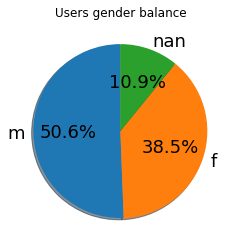

In [6]:
with open('./lastfm_users.json','r') as f:
    users = json.load(f)
gender_balance= defaultdict(int)
for user in users['metadata']:
    gender_balance[user['gender']] += 1
gender_balance

gender_dict= defaultdict(list)
for pos, user in enumerate(users['metadata']):
    gender_dict[(user['gender'])].append(pos)
    
## convert back to dict() to prevent accidental modifications
gender_dict = dict(gender_dict)
    
# extract nan value
nan_value = list(gender_dict.keys())[2]

balance = [(x, len(y)/raw_data['max_user']) for x, y in gender_dict.items()]

plt.title('Users gender balance')
graph = plt.pie([x[1] for x in balance], labels=[x[0] for x in balance], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 18})



## define hyperparameters

In [7]:
dim_embed = 10
total_iter = int(5e3)
eval_iter = 5000
batch_size = 1000
save_iter = eval_iter

## create sampler

In [8]:
from openrec.utils.samplers import RandomPointwiseSampler
# https://github.com/ylongqi/openrec/blob/master/openrec/utils/samplers/random_pointwise_sampler.py 


train_sampler_pointwise = RandomPointwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=5)

## create evaluators and samplers per gender for users

In [9]:
from openrec.utils.samplers import EvaluationSampler
# https://github.com/ylongqi/openrec/blob/master/openrec/utils/samplers/evaluation_sampler.py


evaluator_sampler_dict = dict()
for key, value in gender_dict.items():
  # filter users by gender
  data = np.argwhere(np.in1d(raw_data['test_data']['user_id'], 
                             value) == True)[:, 0]

  # new dataset for test data
  ds = Dataset(raw_data['test_data'][data], raw_data['max_user'],
               raw_data['max_item'], name=str(key), num_negatives=500)
  evaluator_sampler_dict[key] = EvaluationSampler(batch_size=batch_size, dataset=ds)


In [10]:
from openrec.utils.evaluators import AUC, Precision, Recall
# https://github.com/ylongqi/openrec/tree/master/openrec/utils/evaluators

prec_evaluator = Precision(precision_at=[5])
rec_evaluator = Recall(recall_at=[5])
auc_evaluator = AUC()


## create model and model trainer

In [11]:
from openrec.recommenders import PMF
# https://github.com/ylongqi/openrec/blob/master/openrec/recommenders/pmf.py

pmf_model = PMF(batch_size=batch_size, total_users=train_dataset.total_users(), 
                total_items=train_dataset.total_items(), 
                dim_user_embed=dim_embed, dim_item_embed=dim_embed, 
                save_model_dir='pmf_recommender/', train=True, serve=True)



In [12]:
from openrec import ModelTrainer
# https://github.com/ylongqi/openrec/blob/master/openrec/model_trainer.py


model_trainer_pmf = ModelTrainer(model=pmf_model)


W0629 23:16:35.948685 140526982702912 deprecation_wrapper.py:119] From /home/ubuntu/moveable_data/instacart/lib/python3.7/site-packages/openrec/recommenders/recommender.py:263: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0629 23:16:35.950707 140526982702912 deprecation_wrapper.py:119] From /home/ubuntu/moveable_data/instacart/lib/python3.7/site-packages/openrec/recommenders/recommender.py:263: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0629 23:16:35.951776 140526982702912 deprecation_wrapper.py:119] From /home/ubuntu/moveable_data/instacart/lib/python3.7/site-packages/openrec/recommenders/pmf.py:17: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 23:16:35.961064 140526982702912 deprecation.py:506] From /home/ubuntu/moveable_data/instacart/lib/python3.7/site-packages/openrec/modules/extractions/latent_factor.py:7: calling TruncatedNormal.__init__ (from tens

## train simple model

In [13]:
model_trainer_pmf.train(total_iter=total_iter, 
                    eval_iter=eval_iter, 
                    save_iter=save_iter, 
                    train_sampler=train_sampler_pointwise, 
                    eval_samplers=evaluator_sampler_dict.values(), 
                    evaluators=[auc_evaluator, prec_evaluator, rec_evaluator])


[Training starts, total_iter: 5000, eval_iter: 5000, save_iter: 5000]
[iter 5000] Model saved.
[iter 5000] loss: 30.102721
..(dataset: m) evaluation


W0629 23:17:34.546107 140526982702912 deprecation_wrapper.py:119] From /home/ubuntu/moveable_data/instacart/lib/python3.7/site-packages/openrec/recommenders/recommender.py:462: The name tf.train.NewCheckpointReader is deprecated. Please use tf.compat.v1.train.NewCheckpointReader instead.

W0629 23:17:34.568259 140526982702912 deprecation.py:323] From /home/ubuntu/moveable_data/instacart/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


..(dataset: m) AUC 0.7683673833660036
..(dataset: m) Precision 0.6582329317269077
..(dataset: m) Recall 0.09393222674713822
..(dataset: f) evaluation
..(dataset: f) AUC 0.7869427892576011
..(dataset: f) Precision 0.6862433862433862
..(dataset: f) Recall 0.10475213229693789
..(dataset: nan) evaluation
..(dataset: nan) AUC 0.7613560677041215
..(dataset: nan) Precision 0.6841121495327103
..(dataset: nan) Recall 0.10588419875916444


## TODO. Train new model using BPR

* Try to use another model (BPR)
* Use same model parameters
* Use same Samplers and Evaluators
* Use different sampler (RandomPairwiseSampler)





In [15]:
from openrec.recommenders import BPR
from openrec.utils.samplers import RandomPairwiseSampler

In [16]:
### 1. Create new sampler RandomPairwiseSampler
### 2. Create new model BPR
### 3. Create new model trainer with BPR model
### 4. Train model with new sampler RandomPointwiseSampler
### you can reuse same parameters as in previous example

In [17]:
#ANSWER 
train_sampler_pairwise = RandomPairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=5)

bpr_model = BPR(batch_size=batch_size, total_users=train_dataset.total_users(), 
                total_items=train_dataset.total_items(), 
                dim_user_embed=dim_embed, dim_item_embed=dim_embed, 
                save_model_dir='bpr_recommender/', train=True, serve=True)


model_trainer_bpr = ModelTrainer(model=bpr_model)

model_trainer_bpr.train(total_iter=total_iter, 
                    eval_iter=eval_iter, 
                    save_iter=save_iter, 
                    train_sampler=train_sampler_pairwise, 
                    eval_samplers=evaluator_sampler_dict.values(), 
                    evaluators=[auc_evaluator, prec_evaluator, rec_evaluator])



W0629 23:10:23.237165 139831531456320 deprecation.py:323] From /home/ubuntu/moveable_data/instacart/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


OSError: [Errno 12] Cannot allocate memory

# Part 2. Fairness. Balanced user sampling

Some group of users have lower presence in dataset and therefore lower performance. 

In this section, we want to show that OpenRec allows researchers to experiment with sampling data during training.

In [0]:
## let's see again the gender balance for users
graph = plt.pie([x[1] for x in balance], explode=[0,0,.4], labels=[x[0] for x in balance], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 18})


Let's look at "nan" users who are not well represented in dataset and try to write a function that oversamples
them for training

In [0]:
nan_users_list = gender_dict[nan_value]
print('Number of users: ')
len(nan_users_list)

## TODO. Rebalance NAN group to make the performance on this group similar to other groups


* Modify Pointwise sampler to assign larger labels when users belong to NAN category
* Measure effect of your changes
* You can modify method parameters to make it more general
* What are better ways to experiment with fairness?

In [0]:
from openrec.utils.samplers import Sampler

def RandomPointwiseSamplerFair(dataset, batch_size, num_process=5, seed=100):
    
    random.seed(seed)
    def batch(dataset, batch_size=batch_size):
        
        while True:
            input_npy = np.zeros(batch_size, dtype=[('user_id', np.int32),
                                                        ('item_id', np.int32),
                                                        ('label', np.float32)])
            
            for ind in range(batch_size):
                user_id = random.randint(0, dataset.total_users()-1)
                item_id = random.randint(0, dataset.total_items()-1)
                label = 1.0 if dataset.is_positive(user_id, item_id) else 0.0
                ##### START YOUR CODE HERE
                
                # ASSIGN LARGER WEIGHTS TO ENTRIES BY NAN USERS
                
                #ANSWER
                if user_id in nan_users_list:
                  label *= 1.8
                
                ##### END YOUR CODE HERE
                
                input_npy[ind] = (user_id, item_id, label)
            yield input_npy
    
    s = Sampler(dataset=dataset, generate_batch=batch, num_process=num_process)
    
    return s

In [0]:
# create new sampler

train_sampler_pointwise_fair = RandomPointwiseSamplerFair(batch_size=batch_size, dataset=train_dataset, num_process=5)

In [0]:
# use sampler to train your model

pmf_model_fair = PMF(batch_size=batch_size, total_users=train_dataset.total_users(), 
                total_items=train_dataset.total_items(), 
                dim_user_embed=dim_embed, dim_item_embed=dim_embed, 
                save_model_dir='pmf_recommender/', train=True, serve=True)

model_trainer_pmf_fair = ModelTrainer(model=pmf_model_fair)


model_trainer_pmf_fair.train(total_iter=total_iter, 
                    eval_iter=eval_iter, 
                    save_iter=save_iter, 
                    train_sampler=train_sampler_pointwise_fair, 
                    eval_samplers=evaluator_sampler_dict.values(), 
                    evaluators=[auc_evaluator, prec_evaluator, rec_evaluator])


# Part 3. Add some diversity to your items

In this section, we will try to add more diversity to recommendations. We will use very simple design that boosts predictions for rare items in postprocessing step.

Essentially, when the model is served it takes input: ```(user_id, item_id)```. We can find not popular items and set them 

In [0]:
# calculate popularity

item_ids, item_counts = np.unique(raw_data['train_data']['item_id'], return_counts=True)


mean_count = np.mean(item_counts)

plt.hist(item_counts)
print("Mean value: \t", mean_count)
plt.title('item popularity hist.')
plt.xlabel('Number of times items are consumed')
plt.ylabel('Number of items')
plt.yscale('log')

## let's find tail items

In [0]:
print('Total number of items:\t ', item_ids.shape)

In [0]:
## create list of rare items
rare_items = list()
for pos, item_id in enumerate(item_ids):
  if item_counts[pos] < 10:
    rare_items.append(item_id)
rare_items = np.array(rare_items)
print('Number of rare items (less than 10 occurences in train data) :', rare_items.shape)

## calculate predictions for rare and popular items

In [0]:
# ### Default evaluation function:
#
# def _default_eval_iter_func(self, model, batch_data):
#     return np.squeeze(model.serve(batch_data)['outputs'])
#
# ###


# get a sample batch from data
pos_items, batch_data  = evaluator_sampler_dict[nan_value].next_batch()

# get entries for rare and popular items
rare_items_in_batch = np.argwhere(np.in1d(batch_data['item_id'], rare_items) == True)
pop_items_in_batch = np.argwhere(np.in1d(batch_data['item_id'], rare_items) == False)


# calculate predictions for given batch
res = model_trainer_pmf_fair._default_eval_iter_func(pmf_model, batch_data)

print(f'Rare items mean prediction: {np.mean(res[rare_items_in_batch])}')
print(f'Popular items mean prediction: {np.mean(res[pop_items_in_batch])}')

## define function that boosts predictions for rare items

In [0]:
scale_parameter = 2


def diverse_eval_iter_func(model, batch_data):
    rare_items_in_batch = np.argwhere(np.in1d(batch_data['item_id'], rare_items) == True)
    predictions = np.squeeze(model.serve(batch_data)['outputs'])
    predictions[rare_items_in_batch] *= scale_parameter
    return predictions

In [0]:
res_diverse = diverse_eval_iter_func(model_trainer_pmf_fair, batch_data)
print(f'Rare items mean score: {np.mean(res_diverse[rare_items_in_batch])}')
print(f'Popular items mean score: {np.mean(res_diverse[pop_items_in_batch])}')

In [0]:
# train a model that has more diverse predictions

pmf_model_fair_diverse = PMF(batch_size=batch_size, total_users=train_dataset.total_users(), 
                total_items=train_dataset.total_items(), 
                dim_user_embed=dim_embed, dim_item_embed=dim_embed, 
                save_model_dir='pmf_recommender/', train=True, serve=True)

model_trainer_pmf_fair_diverse = ModelTrainer(model=pmf_model_fair_diverse, eval_iter_func=diverse_eval_iter_func)


model_trainer_pmf_fair_diverse.train(total_iter=total_iter, 
                    eval_iter=eval_iter, 
                    save_iter=save_iter, 
                    train_sampler=train_sampler_pointwise_fair, 
                    eval_samplers=evaluator_sampler_dict.values(), 
                    evaluators=[auc_evaluator, prec_evaluator, rec_evaluator])


# Congrats! 

You have trained a simple model and implemented your own sampler that balances users' entries and oversamples gender NAN and added very simple diversity to your recommendations.

* Use it for your problems and let us know about new issues or ideas
* Help us by contributing to the project: https://github.com/ylongqi/openrec


<!-- <p align="left">
 <img src ="https://github.com/ylongqi/openrec-web/raw/gh-pages/openrec.png?raw=true" width="100" height=“20” />
</p> -->


